# This notebook is meant to study effects that depends on the lifetime

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import pandas as pd

import seaborn as sns
from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters, likelihood_levels_1d
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot
from ctau_utils import ctau_heavy
from analyses_dict import analyses
from const import alphaQED
from exp_analysis_class import full_likelihood
from likelihood_contours_plot import set_plot_style, set_canvas_basic, set_plot_title, plot_data_from_analysis

In [3]:
hierarchy = 'heavy'
D_or_M = 'dirac'
save_folder = (f'../fig/4_analysis_variables_plots/')
!mkdir -p $save_folder
save_folder = (f'../fig/4_analysis_variables_plots/{hierarchy}_{D_or_M}_')

set_plot_style()

## Use this to load the datasets in the usual way and dump them in pickle files

In [4]:
# my_exp_analyses = load_datasets(hierarchy, D_or_M, 
#                                 timeit=True, 
#                                 direct_load_objects=False,
#                                 dump=True,
#                                 load_grid=False)

## Use the function this way to load the datasets from the pickle files

In [5]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=True,
                                load_grid=False)

heavy dirac FHC
Wall time: 11.381417036056519 s, CPU time: 1.1573326579999996
heavy dirac RHC
Wall time: 11.352632999420166 s, CPU time: 1.1249152780000014


# N events

In [8]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc_light']], 
                like_normalized=False, 
                is_scan=True)

FHC
RHC


(-0.8788594533304903, 0.28215876998376754, 6.895119755923508e-06)

In [10]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
out = full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['nueccqe_fgd']], 
                like_normalized=False, 
                is_scan=True)

FHC
RHC


In [11]:
out[1].sum()

15.291036595478321

# Detector plot

In [7]:
from parameters_dict import *
aux_binning = []
for splits in detector_splitting_z.values():
    aux_binning += np.linspace(*splits, 10).tolist()
binning_z = np.array(aux_binning)

/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/numpy/lib/histograms.py:1122: RuntimeWarning: invalid value encountered in true_divide
  hist = hist / dedges[i].reshape(shape)


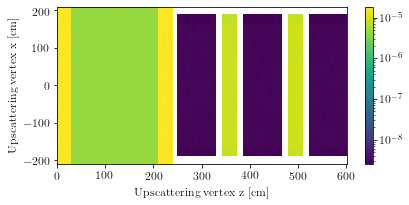

In [12]:
nu_mode = 'FHC'
exp_analysis_obj = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}']
df = exp_analysis_obj.df_base

this_weights = exp_analysis_obj.compute_pot_ntarget_weights(df, 
                            ntarget_per_material=analyses['tpc'][nu_mode]['n_target'],
                            pot=analyses['tpc'][nu_mode]['pot'])


fig = plt.figure(figsize=(6.5,2.9))
plt.hist2d(df['int_point_z'], df['int_point_x'], 
           bins=(binning_z, np.linspace(*detector_splitting_x[0], 20)), 
           weights=this_weights, norm=LogNorm(),
           density=True);
plt.xlabel('Upscattering vertex z [cm]')
plt.ylabel('Upscattering vertex x [cm]')
plt.colorbar()

plt.savefig(save_folder + 'detector_vertex_2d.pdf', bbox_inches='tight')

In [14]:
# ctaus = np.array([0.5, 0.2, 0.1])
ctaus = np.array([100, 1, 0.01])

nu_mode = 'FHC'
aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=ctaus,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

aux_noctau = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_expectation(
                        my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                        m4=physics_parameters['heavy']['bp']['m4'], 
                        mz=physics_parameters['heavy']['bp']['mz'], 
                        alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                        epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                        Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                        Ud4_2=None,
                        external_ctau=None,
                        ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                        pot=analyses['tpc'][nu_mode]['pot'],
                        selection_query=analyses['tpc'][nu_mode]['selection'],
                        efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


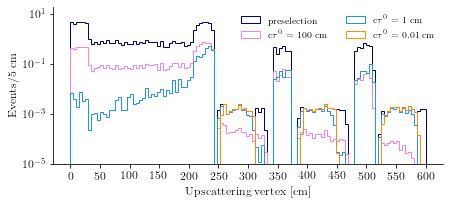

In [7]:
fig = plt.figure(figsize=(7,2.9))

binning = np.linspace(0, 600, 120)
bin_width = binning[1]-binning[0]

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.hist(aux_noctau[0]['int_point_z'],
         bins=binning,
         weights=aux_noctau[1]/bin_width,
         histtype='step',
         color='navy',
         label='preselection')

colors = ['violet', 'dodgerblue', 'darkorange']
for i, ctau in enumerate(ctaus):
    plt.hist(aux[0]['int_point_z'],
             bins=binning,
             weights=aux[1][:, i]/bin_width,
             histtype='step',
             color=colors[i],
             label=f'c$\\tau^0$ = {ctau:.3g} cm')
plt.legend(frameon=False, ncol=2)
plt.yscale('log')
plt.ylim(1e-5, 2e1)
plt.ylabel(f'Events/{bin_width:.2g} cm')
plt.xlabel('Upscattering vertex [cm]')
plt.xticks(np.linspace(0, 600, 13));
# plt.savefig(save_folder+f'int_vertex_z.pdf', bbox_inches='tight')

# Find the c$\tau$ we exclude by varying $V_{ND}$

In [6]:
V_N_2_s = np.geomspace(physics_parameters['heavy']['bp']['Umu4_2'], 1e2, 25)
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['Ud4_2'] = V_N_2_s

ctaus = ctau_heavy(m4=this_point['m4'],
                   mz=this_point['mz'], 
                   Valpha4_alphaepsilon2=this_point['alpha_dark'] * this_point['Ud4_2'] * alphaQED * this_point['epsilon']**2, 
                   D_or_M=D_or_M)

leff = np.zeros(V_N_2_s.shape)
mu_s = np.zeros(V_N_2_s.shape)
sigma2_s = np.zeros(V_N_2_s.shape)
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                 my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                 **this_point, 
                                 analysis=analyses['tpc'][nu_mode], 
                                 like_normalized=True)
    leff += aux[0]
    mu_s += aux[1]
    sigma2_s += aux[3]

leff -= leff.min()

In [7]:
like_interp = interp1d(ctaus, leff-likelihood_levels_1d[0.9], kind='cubic')
r1 = root_scalar(like_interp, method='brentq', bracket=[1e-2, 1], 
                 fprime=None, fprime2=None, x0=0.2, x1=0.15)
r2 = root_scalar(like_interp, method='brentq', bracket=[1e3, 1e5], 
                 fprime=None, fprime2=None, x0=1e4, x1=2e4)

In [8]:
print(r1.root)

0.2523937180016676


(-1.0, 1.0)

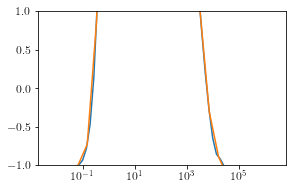

In [9]:
plt.plot(np.geomspace(1e-2, 1e5, 50), like_interp(np.geomspace(1e-2, 1e5, 50)))
plt.plot(ctaus, leff-likelihood_levels_1d[0.9])
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1, 1)

(0.01, 500.0)

<ipython-input-10-e7e1142de228>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))
<ipython-input-10-e7e1142de228>:16: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


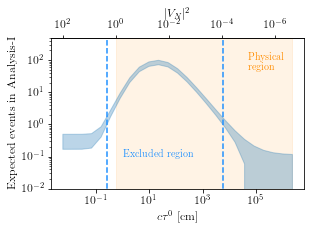

In [10]:
from scipy.interpolate import UnivariateSpline

ax = set_canvas_basic()
ax.set_xlabel('$c\\tau^0$ [cm]')
ax.set_ylabel('Expected events in Analysis-I')
ax.set_xscale('log')
ax.set_yscale('log')

forward_fun = UnivariateSpline(np.log(ctaus[::-1]), np.log(V_N_2_s[::-1]), k=1)
backward_fun = UnivariateSpline(np.log(V_N_2_s), np.log(ctaus), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$|V_N|^2$')
secax.set_ticks

ax.fill_betweenx([1e-2, 1e4], 
                 backward(physics_parameters['heavy']['bp']['Umu4_2']), backward(1), 
                 color='darkorange', alpha=0.1)
ax.annotate('Physical\n region', color='darkorange', xy=(5e4, 5e1))

ax.fill_between(ctaus, mu_s-np.sqrt(sigma2_s), mu_s+np.sqrt(sigma2_s), 
                color='C0', alpha=0.3, label='number of events')
ax.vlines(r1.root, 0, 1e4, color='dodgerblue', ls='--')
ax.vlines(r2.root, 0, 1e4, color='dodgerblue', ls='--')
ax.annotate('Excluded region', color='dodgerblue', xy=(1, 1e-1))
ax.set_ylim(1e-2, 5e2)

# plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.pdf', bbox_inches='tight')
# plt.savefig(save_folder+'n_events_vs_ctau_vs_V_ND.png', bbox_inches='tight', transparent=True, dpi=500)

# Varying the upscattering rate $|V_{\mu N}|^2$

In [11]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] = 0
base_like = full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[0]
base_like *= -1

/n/home00/nfoppiani/projects/dark_nus/exp_analysis/const.py:41: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/G*invGeV_to_cm


In [12]:
from scipy.optimize import curve_fit

def f_fit(ups, t0, c):
    return t0/(np.log10(ups) - c)

In [13]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['external_ctau'] = None
print(full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[1])

562.8474749005045


## Multiple m4, mz

In [14]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['m4'] = 0.3
this_point['mz'] = 0.9
this_point['external_ctau'] = None
print(full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[1])

556.3121179848381


In [15]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['m4'] = 0.05
this_point['mz'] = 2
this_point['external_ctau'] = None
print(full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[1])

102.6210102470533


In [16]:
def interp_and_find_root(like, ctaus):
    like_sign = np.sign(like)
    like_sign_change = np.roll(like_sign, 1) != like_sign
    like_sign_change[0] = False
    out = (np.inf, np.inf)
    if like_sign_change.sum() != 0:
        like_interp = interp1d(ctaus, like, kind='cubic')
        pos1 = np.where(like_sign_change)[0][0]-1
        ctau_1 = root_scalar(like_interp, method='brentq', 
                      bracket=[ctaus[pos1], ctaus[pos1+1]], 
                      fprime=None, fprime2=None, x0=(ctaus[pos1]+ctaus[pos1+1])/2).root
        if like_sign_change.sum() == 2:
            pos2 = np.where(like_sign_change)[0][1]-1
            ctau_2 = root_scalar(like_interp, method='brentq', 
                      bracket=[ctaus[pos2], ctaus[pos2+1]], 
                      fprime=None, fprime2=None, x0=(ctaus[pos2]+ctaus[pos2+1])/2).root
            out = (ctau_1, ctau_2)
        else:
            out = (0, ctau_1)
    return out

In [95]:
# m4_s = [0.2, physics_parameters[hierarchy]['bp']['m4'], 0.05]
# m4_s = [0.2, physics_parameters[hierarchy]['bp']['m4'], 0.05, 0.025]
m4_s = [0.8, 0.5, 0.3, 0.1]
mz_s = [physics_parameters[hierarchy]['bp']['mz']]*len(m4_s)

# m4_s = [physics_parameters[hierarchy]['bp']['m4']]*3
# mz_s = [0.9, physics_parameters[hierarchy]['bp']['mz'], 2]

# m4_s = [physics_parameters[hierarchy]['bp']['m4']]
# mz_s = [physics_parameters[hierarchy]['bp']['mz']]

In [ ]:
ctau_0_s = []
rate_no_ctau = []
for m4, mz in zip(m4_s, mz_s):
    print(m4, mz)
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['m4'] = m4
    this_point['mz'] = mz
    this_point['external_ctau'] = None
    base_rate = full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[1]
    
    Umu4_2_scale_factors = np.concatenate([np.linspace(6/base_rate, 12/base_rate, 12), np.geomspace(20/base_rate, 1e5/base_rate, 20)], axis=0)
    this_point['Umu4_2'] = this_point['Umu4_2']*Umu4_2_scale_factors
     
    this_point['external_ctau'] = None
    rate_no_ctau.append(full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[1])
    
    this_point['external_ctau'] = np.geomspace(0.02, 100000, 30)
    like_ctau = full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[0]
    like_ctau *= -1
    like_ctau -= base_like
    like_ctau -= likelihood_levels_1d[0.9]
    ctau_0_s.append(np.apply_along_axis(interp_and_find_root, 1, like_ctau, this_point['external_ctau']))

0.8 1.25


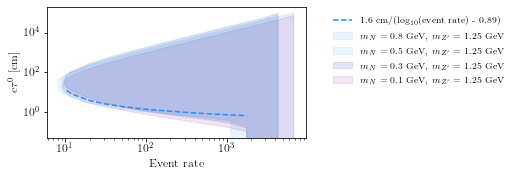

In [100]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
colors = ['dodgerblue', 'deepskyblue', 'navy', 'purple']
for m4, mz, ctau_0, rate, color in zip(m4_s, mz_s, ctau_0_s, rate_no_ctau, colors):
    ax.fill_between(rate,
                    ctau_0[:, 0],
                    ctau_0[:, 1],
                    color=color,
                    alpha=0.1,
                    label=f'$m_N$ = {m4} GeV, $m_{{Z^\prime}}$ = {mz} GeV')

mask = (~np.isinf(ctau_0_s[1][:, 0])) & (ctau_0_s[1][:, 0]!=0) & (rate_no_ctau[1]>10) 
out_fit_rate = curve_fit(f_fit, rate_no_ctau[1][mask], ctau_0_s[1][:, 0][mask], p0=(0.1, 1))
ax.plot(rate_no_ctau[1][mask],
        f_fit(rate_no_ctau[1][mask], *out_fit_rate[0]),
        '--',
        color='dodgerblue',
        label=f'{out_fit_rate[0][0]:.2g} cm/($\log_{{10}}$(event rate) - {out_fit_rate[0][1]:.2g})')

ax.legend(bbox_to_anchor=[1.8, 1])
ax.set_xlabel('Event rate')
ax.set_ylabel(r'$c \tau^0$ [cm]')
ax.set_xscale('log')
ax.set_yscale('log')
# plt.savefig(save_folder + 'ctau_vs_rate_three_points_shaded_varying_mn_4points.pdf', bbox_inches='tight')

Text(0.0, 1.0, 'Analysis-I, $m_{Z^\\prime}$ = 1.25 GeV')

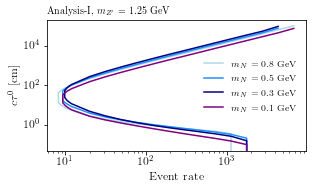

In [101]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
colors = ['lightblue', 'dodgerblue', 'navy', 'purple']
for i, (m4, ctau_0, rate, color) in enumerate(zip(m4_s, ctau_0_s, rate_no_ctau, colors)):
    x_s = np.concatenate((rate[::-1], rate))
    y_s = np.concatenate((ctau_0[:, 0][::-1], ctau_0[:, 1]))
    mask = ~np.isinf(y_s)
    ax.plot(x_s[mask], y_s[mask],
            color=color,
            label=f'$m_N$ = {m4} GeV')

ax.legend()
ax.set_xlabel('Event rate')
ax.set_ylabel(r'$c \tau^0$ [cm]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'Analysis-I, $m_{{Z^\prime}}$ = {mz_s[0]} GeV', loc='left')
# plt.savefig(save_folder + 'ctau_vs_rate_4points_noshade.pdf')

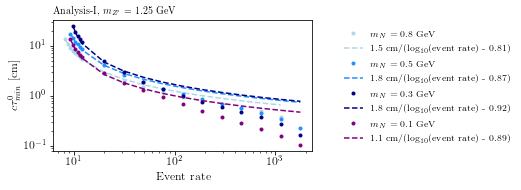

In [104]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xscale('log')

colors = ['lightblue', 'dodgerblue', 'navy', 'purple']

for m4, mz, ctau_0, rate, color in zip(m4_s, mz_s, ctau_0_s, rate_no_ctau, colors):
    mask = (~np.isinf(ctau_0[:, 0])) & (ctau_0[:, 0]!=0) 
    ax.plot(rate[mask],
            ctau_0[:, 0][mask], 
            '.',
            color=color,
            label=f'$m_N$ = {m4} GeV')
    
    out_fit_rate = curve_fit(f_fit, rate[mask], ctau_0[:, 0][mask], p0=(0.1, 0.5))
    ax.plot(rate[mask],
            f_fit(rate[mask], *out_fit_rate[0]),
            '--',
            color=color,
            label=f'{out_fit_rate[0][0]:.2g} cm/($\log_{{10}}$(event rate) - {out_fit_rate[0][1]:.2g})')

ax.legend(bbox_to_anchor=[1.8, 1])
ax.set_title(f'Analysis-I, $m_{{Z^\prime}}$ = {mz_s[0]} GeV', loc='left')
ax.set_xlabel('Event rate')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
ax.set_yscale('log')
plt.savefig(save_folder + 'ctau_vs_rate_4points_with_fit_large_mn.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Event rate, from low to high')

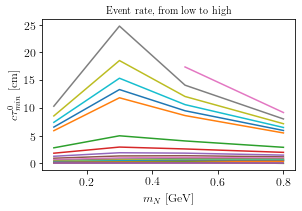

In [102]:
ax = set_canvas_basic()

for i, rate in enumerate(rate_no_ctau[0]):
    # print([ctau_0_s[j][i, 0] for j in range(len(ctau_0_s))])
    ax.plot(m4_s, [ctau_0_s[j][i, 0] for j in range(len(ctau_0_s))])
    
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
ax.set_title('Event rate, from low to high')
# ax.set_yscale('log')

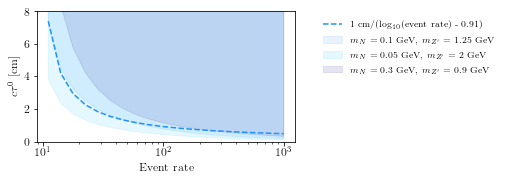

In [53]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xscale('log')

colors = ['dodgerblue', 'deepskyblue', 'navy']
for m4, mz, ctau_0_min, rate, color in zip(m4_s, mz_s, ctau_0_min_s, rate_no_ctau, colors):
    ax.fill_between(rate,
                    ctau_0_min,
                    100,
                    color=color,
                    alpha=0.1,
                    label=f'$m_N$ = {m4} GeV, $m_{{Z^\prime}}$ = {mz} GeV')
    
out_fit_rate = curve_fit(f_fit, rate_no_ctau[0], ctau_0_min_s[0], p0=(0.1, 1))
ax.plot(rate_no_ctau[0],
        f_fit(rate_no_ctau[0], *out_fit_rate[0]),
        '--',
        color='dodgerblue',
        label=f'{out_fit_rate[0][0]:.2g} cm/($\log_{{10}}$(event rate) - {out_fit_rate[0][1]:.2g})')

ax.legend(bbox_to_anchor=[1.8, 1])
ax.set_xlabel('Event rate')
ax.set_ylabel(r'$c \tau^0$ [cm]')
ax.set_ylim(0, 8)
plt.savefig(save_folder + 'ctau_vs_rate_three_points_shaded_only_min.pdf', bbox_inches='tight')

# Old material

In [10]:
ctau_0_min_s = []
rate_no_ctau = []
for V_muN_2 in V_muN_2_s:
    aux = {}
    aux_rate_no_ctau = 0
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['Umu4_2'] = V_muN_2
    
    for nu_mode in ['FHC', 'RHC']:
        this_point['external_ctau'] = None
        aux_rate_no_ctau += my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                     **this_point, 
                                     analysis=analysis_tpc_no_argon[nu_mode], 
                                     like_normalized=False)[1]
        
        this_point['external_ctau'] = np.geomspace(0.001, 100, 20)
        aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                     **this_point, 
                                     analysis=analysis_tpc_no_argon[nu_mode], 
                                     like_normalized=False)
    
    rate_no_ctau.append(aux_rate_no_ctau)
    leff = aux['FHC'][0] + aux['RHC'][0]
    leff *= -1
    leff -= base_like
    like_interp = interp1d(this_point['external_ctau'], 
                           leff-likelihood_levels_1d[0.9], 
                           kind='cubic')
    try:
        aux = root_scalar(like_interp, method='brentq', 
                          bracket=[this_point['external_ctau'][0], this_point['external_ctau'][-1]], 
                          fprime=None, fprime2=None, x0=(this_point['external_ctau'][0]+this_point['external_ctau'][-1])/2).root
    except:
        aux = None
    ctau_0_min_s.append(aux)

In [11]:
from scipy.optimize import curve_fit

def f_fit(ups, t0, c):
    return t0/(np.log10(ups) - c)

def f_fit_adv(ups, t0, c, gamma):
    return t0/(np.log10(ups) - np.log10(1-gamma*ups) - c)

In [12]:
out_fit = curve_fit(f_fit, V_muN_2_s, ctau_0_min_s, p0=(1, -8.5))

In [82]:
out_fit_rate = curve_fit(f_fit, rate_no_ctau, ctau_0_min_s, p0=(0.1, 1))

In [83]:
out_fit_rate

(array([0.85438476, 0.97338253]),
 array([[ 0.00401608, -0.00117395],
        [-0.00117395,  0.00041316]]))

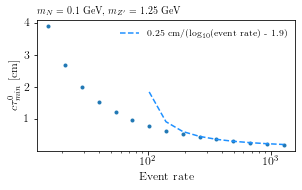

In [26]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xscale('log')
ax.plot(rate_no_ctau,
        ctau_0_min_s, 
        '.',)

ax.plot(rate_no_ctau,
        f_fit(rate_no_ctau, *out_fit_rate[0]),
        '--',
        color='dodgerblue',
        label=f'{out_fit_rate[0][0]:.2g} cm/($\log_{{10}}$(event rate) - {out_fit_rate[0][1]:.2g})')
ax.legend()
ax.set_xlabel('Event rate')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')

this_point_for_title = deepcopy(this_point)
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['alpha_dark'] = None
this_point_for_title['epsilon'] = None
this_point_for_title['external_ctau'] = None
set_plot_title(ax, 
               **this_point_for_title
               )

# plt.savefig(save_folder + 'ctau_vs_rate_final.pdf')

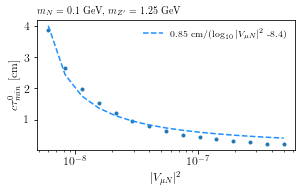

In [18]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xscale('log')
ax.plot(V_muN_2_s,
        ctau_0_min_s, 
        '.')

ax.plot(V_muN_2_s,
        f_fit(V_muN_2_s, *out_fit[0]),
        '--',
        color='dodgerblue',
        label=f'{out_fit[0][0]:.2g} cm/($\log_{{10}}|V_{{\mu N}}|^2$ {out_fit[0][1]:.2g})')

ax.legend()
ax.set_xlabel(r'$|V_{\mu N}|^2$')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')

this_point_for_title = deepcopy(this_point)
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['alpha_dark'] = None
this_point_for_title['epsilon'] = None
this_point_for_title['external_ctau'] = None
set_plot_title(ax, 
               **this_point_for_title
               )

# plt.savefig(save_folder + 'ctau_vs_rate_final.pdf')

In [99]:
def f_fit_mixture(tau, c, alpha, t1, t2):
    return c/(alpha*np.exp(-t1/tau) + (1-alpha)*np.exp(-t2/tau))

In [113]:
out_fit_mix = curve_fit(f_fit_mixture, ctau_0_min_s, rate_no_ctau, p0=(15, 0.6, 0.8, 3), bounds=((0, 0, 0, 0), (np.inf, 1, np.inf, np.inf)))

In [114]:
out_fit_mix[0]

array([14.31862834,  0.13804614,  0.49668912,  1.89535579])

No handles with labels found to put in legend.


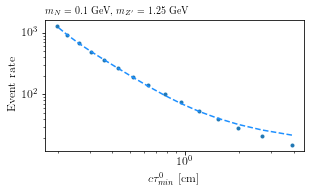

In [116]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xscale('log')
ax.plot(ctau_0_min_s, 
        rate_no_ctau,
        '.',)

ax.plot(ctau_0_min_s,
        f_fit_mixture(np.array(ctau_0_min_s), *out_fit_mix[0]),
        '--',
        color='dodgerblue',
        # label=f'{out_fit_rate[0][0]:.2g} cm/($\log_{{10}}$(event rate) - {out_fit_rate[0][1]:.2g})')
       )
ax.legend()
ax.set_ylabel('Event rate')
ax.set_xlabel(r'$c \tau^0_{min}$ [cm]')
ax.set_yscale('log')
this_point_for_title = deepcopy(this_point)
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['alpha_dark'] = None
this_point_for_title['epsilon'] = None
this_point_for_title['external_ctau'] = None
set_plot_title(ax, 
               **this_point_for_title
               )

# plt.savefig(save_folder + 'ctau_vs_rate_final.pdf')

## for different $m_N$

In [5]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['epsilon'] = 1e-20

base_like = 0
for nu_mode in ['FHC', 'RHC']:
    aux = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base,
                                     **this_point, 
                                     analysis=analyses['tpc'][nu_mode], 
                                     like_normalized=False)
    base_like += (-aux[0])

In [12]:
def get_ctau0_min(this_point, base_like):
    aux = {}
    for nu_mode in ['FHC', 'RHC']:
        aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                     my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                     **this_point, 
                                     analysis=analyses['tpc'][nu_mode], 
                                     like_normalized=False)

    leff = aux['FHC'][0] + aux['RHC'][0]
    # mu_s = aux['FHC'][1] + aux['RHC'][1]
    # sigma2_s = aux['FHC'][3] + aux['RHC'][3]
    leff *= -1
    leff -= base_like
    
    like_interp = interp1d(this_point['external_ctau'], 
                           leff-likelihood_levels_1d[0.9], 
                           kind='cubic')
    print(this_point['external_ctau'])
    print(leff-likelihood_levels_1d[0.9])
    try:
        aux = root_scalar(like_interp, method='brentq', 
                          bracket=[this_point['external_ctau'][0], this_point['external_ctau'][-1]], 
                          fprime=None, fprime2=None, x0=(this_point['external_ctau'][0]+this_point['external_ctau'][-1])/2).root
    except:
        aux = None
        
    return aux

In [44]:
m4_s = np.linspace(0.01, 0.5, 12)
ctau_min_s = []
for m4 in m4_s:
    # print(m4)
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['m4'] = m4
    this_point['external_ctau'] = np.geomspace(0.001, 15, 20)
    for i in range(1, 2):
        ctau_min = get_ctau0_min(this_point, base_like)
        # print(ctau_min)
        # this_point['external_ctau'] = np.geomspace(ctau_min/(1+1/i**2), ctau_min*(1+1/i**2), 20)
        
    ctau_min_s.append(ctau_min)

[1.00000000e-03 1.65880096e-03 2.75162061e-03 4.56439090e-03
 7.57141598e-03 1.25594721e-02 2.08336642e-02 3.45589021e-02
 5.73263399e-02 9.50929874e-02 1.57740338e-01 2.61659824e-01
 4.34041566e-01 7.19988564e-01 1.19431772e+00 1.98113537e+00
 3.28630925e+00 5.45133292e+00 9.04267625e+00 1.50000000e+01]
[-0.97068091 -0.97028153 -0.96937523 -0.96510683 -0.93742332 -0.80128024
 -0.30448248  1.06372612  3.86126166  9.07530081 17.43367671 27.68056444
 37.11676934 44.28224416 49.41712301 52.37321198 52.11592882 48.15547353
 41.2307651  32.80563746]
[1.00000000e-03 1.65880096e-03 2.75162061e-03 4.56439090e-03
 7.57141598e-03 1.25594721e-02 2.08336642e-02 3.45589021e-02
 5.73263399e-02 9.50929874e-02 1.57740338e-01 2.61659824e-01
 4.34041566e-01 7.19988564e-01 1.19431772e+00 1.98113537e+00
 3.28630925e+00 5.45133292e+00 9.04267625e+00 1.50000000e+01]
[-0.95255646 -0.95243769 -0.9523855  -0.95242291 -0.9525349  -0.95271112
 -0.95181791 -0.9398504  -0.86255484 -0.52671995  0.45837302  2.641632

In [45]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

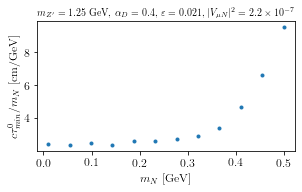

In [46]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)

ax.plot(m4_s,
         ctau_min_s/m4_s, 
         '.')
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min} /m_N$ [cm/GeV]')
set_plot_title(ax, 
               **this_point_for_title
               )
# plt.savefig(save_folder + 'ctau_div_mn_vs_mn.pdf')

In [47]:
from numpy.polynomial import Polynomial

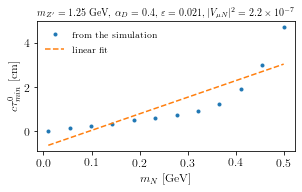

In [48]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)

ax.plot(m4_s,
         ctau_min_s, 
         '.',
        label='from the simulation')

lin_fit = Polynomial.fit(m4_s, ctau_min_s, deg=1)
ax.plot(m4_s, lin_fit(m4_s), 
         '--', label='linear fit')
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
ax.legend()
set_plot_title(ax, 
               **this_point_for_title
               )
# plt.savefig(save_folder + 'ctau_vs_mn.pdf')

## Versus rate

In [49]:
rates = np.zeros(m4_s.shape)

for i, m4 in enumerate(m4_s):
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['m4'] = m4
    this_point['external_ctau'] = None
    
    aux = {}
    for nu_mode in ['FHC', 'RHC']:
        aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                         my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                         **this_point, 
                                         analysis=analyses['tpc'][nu_mode], 
                                         like_normalized=False)

    rates[i] = aux['FHC'][1] + aux['RHC'][1]

Text(0, 0.5, 'Upscattering rate')

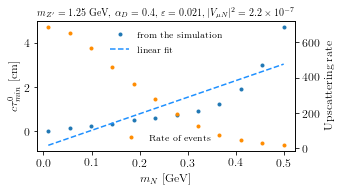

In [50]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)

ax.plot(m4_s,
         ctau_min_s, 
         '.',
        label='from the simulation')

lin_fit = Polynomial.fit(m4_s, ctau_min_s, deg=1)
ax.plot(m4_s, lin_fit(m4_s), 
         '--',
         color='dodgerblue', label='linear fit')
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
ax.legend(loc='upper center')
set_plot_title(ax, 
               **this_point_for_title
               )

ax2 = ax.twinx()
ax2.plot(m4_s,
         rates,
         '.',
         color='darkorange',
         label='Rate of events')
ax2.legend(loc='lower center')
ax2.set_ylabel('Upscattering rate')
# plt.savefig(save_folder + 'ctau_vs_mn_and_rate.pdf')

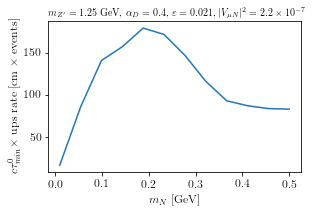

In [51]:
ax = set_canvas_basic()

ax.plot(m4_s, ctau_min_s*rates)
ax.set_xlabel(r'$m_N$ [GeV]')
ax.set_ylabel(r'$c \tau^0_{min} \times$ ups rate [cm $\times$ events]')
set_plot_title(ax, 
               **this_point_for_title
               )
# plt.savefig(save_folder + 'ctau_times_rate_vs_mn.pdf')

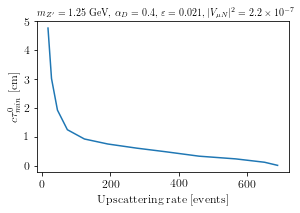

In [52]:
ax = set_canvas_basic()

ax.plot(rates, ctau_min_s)

ax.set_xlabel(r'Upscattering rate [events]')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(ax, 
               **this_point_for_title
               )
# plt.savefig(save_folder + 'ctau_vs_rate.pdf')

## Let's vary only the upscattering rate

In [53]:
Umu4_2_s = np.geomspace(2e-8, 2e-6, 10)

In [54]:
ctau_min_s = []
rates = []
for Umu4_2 in Umu4_2_s:
    this_point = deepcopy(physics_parameters[hierarchy]['bp'])
    this_point['Umu4_2'] = Umu4_2
    this_point['external_ctau'] = np.geomspace(0.001, 15, 20)
    for i in range(1, 2):
        ctau_min = get_ctau0_min(this_point, base_like)
        # print(ctau_min)
        # this_point['external_ctau'] = np.geomspace(ctau_min/(1+1/i**2), ctau_min*(1+1/i**2), 20)
    ctau_min_s.append(ctau_min)
    
    aux = {}
    this_point['external_ctau'] = None
    for nu_mode in ['FHC', 'RHC']:
        aux[nu_mode] = my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].compute_likelihood_from_pars(
                                         my_exp_analyses[f'{hierarchy}_{D_or_M}_{nu_mode}'].df_base, 
                                         **this_point, 
                                         analysis=analyses['tpc'][nu_mode], 
                                         like_normalized=False)
    rates.append(aux['FHC'][1] + aux['RHC'][1])

[1.00000000e-03 1.65880096e-03 2.75162061e-03 4.56439090e-03
 7.57141598e-03 1.25594721e-02 2.08336642e-02 3.45589021e-02
 5.73263399e-02 9.50929874e-02 1.57740338e-01 2.61659824e-01
 4.34041566e-01 7.19988564e-01 1.19431772e+00 1.98113537e+00
 3.28630925e+00 5.45133292e+00 9.04267625e+00 1.50000000e+01]
[-1.32452827 -1.32453017 -1.32452873 -1.32451997 -1.3245041  -1.32448568
 -1.32446776 -1.32437139 -1.3234652  -1.31782044 -1.29349193 -1.22038223
 -1.05315641 -0.7151582  -0.06253633  1.06539104  2.54182942  3.98824603
  5.10548507  5.80046486]
[1.00000000e-03 1.65880096e-03 2.75162061e-03 4.56439090e-03
 7.57141598e-03 1.25594721e-02 2.08336642e-02 3.45589021e-02
 5.73263399e-02 9.50929874e-02 1.57740338e-01 2.61659824e-01
 4.34041566e-01 7.19988564e-01 1.19431772e+00 1.98113537e+00
 3.28630925e+00 5.45133292e+00 9.04267625e+00 1.50000000e+01]
[-1.30417968 -1.30418284 -1.30418044 -1.30416585 -1.30413938 -1.30410867
 -1.30407879 -1.30391813 -1.3024072  -1.29299415 -1.25242978 -1.130646

In [55]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

No handles with labels found to put in legend.


Text(0, 0.5, 'Upscattering rate')

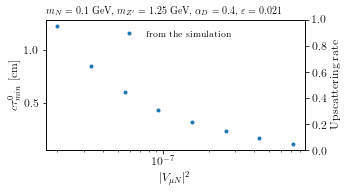

In [59]:
fig = plt.figure()
axes_form = [0.17,0.19,0.81,0.64]
ax = fig.add_axes(axes_form)
ax.set_xscale('log')
ax.plot(Umu4_2_s,
         ctau_min_s, 
         '.',
        label='from the simulation')

ax.set_xlabel(r'$|V_{\mu N}|^2$')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
ax.legend(loc='upper center')
set_plot_title(ax, 
               **this_point_for_title
               )

ax2 = ax.twinx()
# ax2.plot(Umu4_2_s,
#          rates,
#          '.',
#          color='darkorange',
#          label='Rate of events')
ax2.legend(loc='lower center')
ax2.set_ylabel('Upscattering rate')
# plt.savefig(save_folder + 'ctau_vs_mn_and_rate.pdf')

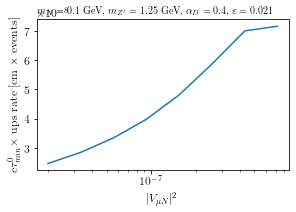

In [72]:
ax = set_canvas_basic()

ax.plot(Umu4_2_s[:-2], ctau_min_s[:-2]*Umu4_2_s[:-2])
ax.set_xlabel(r'$|V_{\mu N}|^2$')
ax.set_ylabel(r'$c \tau^0_{min} \times$ ups rate [cm $\times$ events]')
set_plot_title(ax, 
               **this_point_for_title
               )
ax.set_xscale('log')
# plt.savefig(save_folder + 'ctau_times_rate_vs_mn.pdf')

In [ ]:
ax = set_canvas_basic()

ax.plot(rates, ctau_min_s)

ax.set_xlabel(r'Upscattering rate [events]')
ax.set_ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(ax, 
               **this_point_for_title
               )
# plt.savefig(save_folder + 'ctau_vs_rate.pdf')

## Varying m_Z

In [75]:
mz_s = np.linspace(1, 2, 3)
m4_s = np.linspace(0.01, 0.2, 4)
ctau_min_s = []

In [76]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

for mz in mz_s:
    this_point['mz'] = mz
    print(f'mz = {mz}')
    ctau_min_s.append([])
    for m4 in m4_s:
        print(f'm4 = {m4}')
        this_point['m4'] = m4
        this_point['external_ctau'] = np.geomspace(0.001, 10, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        
        ctau_min_s[-1].append(ctau_min)

mz = 1.0
m4 = 0.01
[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
[-0.30663739 -0.30469951 -0.3014361  -0.28232379 -0.1713907   0.32385313
  1.81990605  4.90268    10.2773372  19.83738831 34.98031378 52.94910405
 69.10817452 81.02280027 89.05173607 94.34996948 96.69212032 94.95040236
 88.76763849 78.92179037]
[0.00444277 0.00477905 0.00514078 0.00552988 0.00594844 0.00639869
 0.00688301 0.00740398 0.0079644  0.00856723 0.00921568 0.00991323
 0.01066356 0.01147069 0.01233892 0.01327286 0.01427749 0.01535816
 0.01652063 0.01777108]
[-0.27886947 -0.27053487 -0.25972128 -0.24576755 -0.22785472 -0.20497756
 -0.17591662 -0.13921445 -0.09315998 -0.03578688  0.03510899  0.1219289
  0.22720657  0.35352402  0.50341743  0.6792869   0.88332411

In [78]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['mz'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

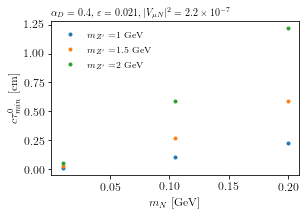

In [80]:
for i, mz in enumerate(mz_s):
    plt.plot(m4_s,
             ctau_min_s[i], 
             '.',
             label=r'$m_{Z^{\prime}}$ = '+f'{mz:.3g} GeV')
    
plt.legend(frameon=False)
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn_mz.pdf', bbox_inches='tight')

## Varying V_muN

In [88]:
Umu4_2_s = [2e-8, 1e-7, 5e-7]
m4_s = np.linspace(0.01, 0.2, 3)
ctau_min_s = []

In [90]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

for Umu4_2 in Umu4_2_s:
    this_point['Umu4_2'] = Umu4_2
    print(f'Umu4_2 = {Umu4_2}')
    ctau_min_s.append([])
    for m4 in m4_s:
        print(f'm4 = {m4}')
        this_point['m4'] = m4
        this_point['external_ctau'] = np.geomspace(0.001, 10, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
        ctau_min = get_ctau0_min(this_point, base_like)
        
        ctau_min_s[-1].append(ctau_min)

Umu4_2 = 2e-08
m4 = 0.01
[1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
[-1.30944584 -1.30957986 -1.30972962 -1.30955667 -1.30575157 -1.28376917
 -1.21102335 -1.04714914 -0.7412019  -0.14488549  1.07847667  3.11986119
  5.63008451  7.85123903  9.40069017 10.34188305 10.61890805 10.00249697
  8.50494359  6.49708658]
[0.04243187 0.04564356 0.04909835 0.05281464 0.05681221 0.06111236
 0.06573799 0.07071373 0.0760661  0.08182358 0.08801686 0.09467891
 0.10184521 0.10955393 0.11784613 0.12676598 0.13636097 0.14668221
 0.15778467 0.16972749]
[-0.84257937 -0.78790351 -0.72765633 -0.6610637  -0.58723025 -0.50514051
 -0.41366637 -0.31158156 -0.19758391 -0.0703256   0.07154884  0.22935748
  0.40433015  0.59755345  0.82760316  1.06105799  1.3

In [92]:
this_point_for_title = deepcopy(this_point)
this_point_for_title['m4'] = None
this_point_for_title['Umu4_2'] = None
this_point_for_title['Ud4_2'] = None
this_point_for_title['external_ctau'] = None

In [94]:
ctau_min_s

[[],
 [0.08491952405258103, 0.8923183303210169, 1.881067492078531],
 [0.027742591261226305, 0.31031759665909164, 0.6133165629715931],
 [0.008539613004478667, 0.11520381807737003, 0.2483787411900989]]

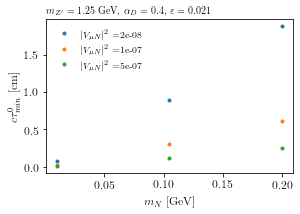

In [96]:
for i, Umu4_2 in enumerate(Umu4_2_s):
    plt.plot(m4_s,
             ctau_min_s[i+1], 
             '.',
             label=r'$|V_{\mu N}|^2$ ='+f'{Umu4_2:.3g}')
    
plt.legend(frameon=False)
plt.xlabel(r'$m_N$ [GeV]')
plt.ylabel(r'$c \tau^0_{min}$ [cm]')
set_plot_title(plt.gca(), 
               **this_point_for_title
               )
plt.savefig(save_folder + 'ctau_vs_mn_Umu4_2.pdf', bbox_inches='tight')

## Varying both

In [63]:
mz_s = np.linspace(1, 2, 8)
Umu4_2_s = np.linspace(2e-8, 1e-6, 7)
m4_s = np.linspace(0.01, 0.2, 10)
mz_s, Umu4_2_s, m4_s = np.meshgrid(mz_s, Umu4_2_s, m4_s, indexing='ij')
ctau_min_s = np.zeros(shape=(len(mz_s), len(Umu4_2_s), len(m4_s)))

In [66]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])

def get_ctau0_min_from_pars(mz, Umu4_2, m4):
    print(mz, Umu4_2, m4)
    this_point['mz'] = mz
    this_point['Umu4_2'] = Umu4_2
    this_point['m4'] = m4
    this_point['external_ctau'] = np.geomspace(0.01, 10, 20)
    # ctau_min = get_ctau0_min(this_point, base_like)
    # this_point['external_ctau'] = np.geomspace(ctau_min/2, ctau_min*2, 20)
    return get_ctau0_min(this_point, base_like)

get_ctau0_min_from_pars_v = np.vectorize(get_ctau0_min_from_pars)

In [67]:
ctau_min_s = get_ctau0_min_from_pars_v(mz_s, Umu4_2_s, m4_s)

1.0 2e-08 0.01
[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]
[-1.27033613 -1.2539807  -1.20221934 -1.08168746 -0.85138856 -0.43982289
  0.32509934  1.62834371  3.64032267  6.24312973  9.03200867 11.57913527
 13.68444121 15.33280601 16.47578107 16.94056725 16.55326932 15.30105451
 13.37033409 11.0651623 ]
1.0 2e-08 0.01
[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]
[-1.27033613 -1.2539807  -1.20221934 -1.08168746 -0.85138856 -0.43982289
  0.32509934  1.62834371  3.64032267  6.24312973  9.03200867 11.57913527
 13.68444121 15.33280601 16.47578107 16.94056725 16.55326932 15.30105451
 13.37033409 11.

In [69]:
ctau_min_s.shape

(2, 3, 3)

In [73]:
def return_coeff_oned_fit(ctau_min_s, m4_s=np.linspace(0.01, 0.2, 3)):
    print(m4_s)
    print(ctau_min_s)
    try:
        aux = Polynomial.fit(m4_s, ctau_min_s, deg=1).coef[1]
    except:
        aux = None
    return aux

In [74]:
ctau_0_min_mn_slopes = np.apply_along_axis(return_coeff_oned_fit, axis=2, arr=ctau_min_s)

[0.01  0.105 0.2  ]
[0.07783145 0.66816657 1.3793889 ]
[0.01  0.105 0.2  ]
[0.02988452 0.23958798 0.49239981]
[0.01  0.105 0.2  ]
[       nan        nan 0.13923624]
[0.01  0.105 0.2  ]
[nan nan nan]
[0.01  0.105 0.2  ]
[0.13121194 1.6136665  3.83351136]
[0.01  0.105 0.2  ]
[0.04422519 0.50369218 0.93994232]


In [82]:
ctau_0_min_mn_slopes

array([[0.65077873, 0.23125765,        nan],
       [       nan, 1.85114971, 0.44785857]])

In [89]:
mz_s

array([1., 2.])

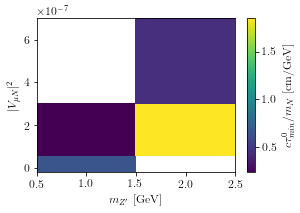

In [93]:
mz_s = np.linspace(1, 2, 2)
Umu4_2_s = [2e-8, 1e-7, 5e-7]
plt.pcolormesh(mz_s, Umu4_2_s, ctau_0_min_mn_slopes.T, shading='nearest')
plt.xlabel(r'$m_{Z^{\prime}}$ [GeV]')
plt.ylabel(r'$|V_{\mu N}|^2$')
plt.colorbar(label=r'$c \tau^0_{min} /m_N$ [cm/GeV]')

# Geometrical acceptance

In [6]:
ctaus = np.geomspace(1e-2, 1e4, 20)

mu_s = {}
sigma2_s = {}

mu_s_noctau = {}
sigma2_s_noctau = {}

materials = ['lead', 'argon']
for selection in materials:
    mu_s[selection] = 0
    sigma2_s[selection] = 0
    mu_s_noctau[selection] = 0
    sigma2_s_noctau[selection] = 0
    for nu_mode in ['FHC', 'RHC']:
        aux = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=ctaus,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s[selection] += aux[1].sum(axis=0)
        sigma2_s[selection] += (aux[1]**2).sum(axis=0)
        
        aux_noctau = my_exp_analyses[f'heavy_majorana_{nu_mode}'].compute_expectation(
                                    my_exp_analyses[f'heavy_majorana_{nu_mode}'].df_base, 
                                    m4=physics_parameters['heavy']['bp']['m4'], 
                                    mz=physics_parameters['heavy']['bp']['mz'], 
                                    alpha_dark=physics_parameters['heavy']['bp']['alpha_dark'], 
                                    epsilon=physics_parameters['heavy']['bp']['epsilon'], 
                                    Umu4_2=physics_parameters['heavy']['bp']['Umu4_2'], 
                                    Ud4_2=None,
                                    external_ctau=None,
                                    ntarget_per_material=analyses['tpc'][nu_mode]['n_target'], 
                                    pot=analyses['tpc'][nu_mode]['pot'],
                                    selection_query=analyses['tpc'][nu_mode]['selection'] + " & " + selection,
                                    efficiency_factor=analyses['tpc'][nu_mode]['efficiency'])
        mu_s_noctau[selection] += aux_noctau[1].sum(axis=0)
        sigma2_s_noctau[selection] += (aux_noctau[1]**2).sum(axis=0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


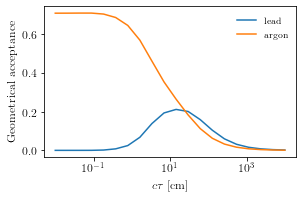

In [7]:
ax = set_canvas_basic()

for selection in materials:     
    ax.plot(ctaus, mu_s[selection]/mu_s_noctau[selection], label=selection)

ax.set_xlabel('$c\\tau$ [cm]')
ax.set_ylabel('Geometrical acceptance')
ax.set_xscale('log')
ax.legend(frameon=False, loc='upper right')


# plt.savefig(save_folder+'geometrical_acceptance.pdf', bbox_inches='tight', transparent=True)
# plt.savefig(save_folder+'geometrical_acceptance.png', bbox_inches='tight', dpi=500, transparent=True)

# Efficiency versus m4, mz

In [ ]:
this_point = deepcopy(physics_parameters[hierarchy]['bp'])
this_point['m4'] = np.geomspace(*physics_parameters['heavy']['m4_limits'], 15)[1:-1]
this_point['mz'] = np.geomspace(*physics_parameters['heavy']['mz_limits'], 15)[1:-1]
this_point['external_ctau'] = None

selected_events_num = full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analyses['tpc']], 
                like_normalized=False, 
                is_scan=True)[1]

analysis_tpc_no_eff = deepcopy(analyses['tpc'])
for sub_analysis in analysis_tpc_no_eff.values():
    sub_analysis['selection'] = None

selected_events_den = full_likelihood(**this_point, 
                exp_analyses_objects=my_exp_analyses, 
                hierarchy=hierarchy, 
                D_or_M=D_or_M, 
                analyses=[analysis_tpc_no_eff], 
                like_normalized=False, 
                is_scan=True)[1]

selection_efficiency = selected_events_num/selected_events_den

In [ ]:
from plot_utils import annotated_2d_plot

ax = set_canvas_basic()

annotated_2d_plot(selection_efficiency, 
                  this_point['m4'], 
                  this_point['mz'], 
                  xlabel=r'$m_N$ [GeV]', 
                  ylabel=r'$m_Z^{\prime}$ [GeV]', 
                  colornorm='normal', 
                  ax=ax,
                  in_log=True)

ax.set_title('Heavy mediator, FHC + RHC fluxes')
# plt.savefig(save_folder + 'selection_efficiency_vs_mn_mz.pdf')

In [ ]:
from scipy.interp import griddata

In [ ]:
ax = set_canvas_basic()

ax.pcolormesh(this_point['m4'], 
              this_point['mz'], 
              selection_efficiency(